# Configuration

Setup the following:
- data directory
- env vars

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anthropic
import IPython as ipython
from base64 import b64decode

In [3]:
import bizwiz
bizwiz.load_llm_env()

path_manager = bizwiz.PathManager(
    data_dir = "../data/"
)

chat_manager = bizwiz.ChatManager(temperature=0.0)

In [4]:
image_filepaths = path_manager.find_data_files(suffix='PNG')
image_filepaths

['../data/Capture1.PNG',
 '../data/Capture2.PNG',
 '../data/Capture4.PNG',
 '../data/Capture.PNG',
 '../data/Capture5.PNG',
 '../data/Capture3.PNG']

In [ ]:
image_filepath = image_filepaths[0]
answer = chat_manager.prompt(
    text="""Attached is an image of a data table that I want to extract data from.

    The table has multiple columns in a header that includes merged cells:
    - a temperature column
    - a liquid concentration for H2SO4
    - a liquid concentration for Na2SO4
    - a solid phase column with the chemical formula as the value

    Please reflect on this description as well as the image and think about how you would extract the data into a csv format.
    - include thoughts on the values that each column has (float, int, text, etc)
    - include thoughts on what blanks might mean in each column (blanks should be filled with previous value, blanks are meaningful values, etc)
    - include any special or unexpected values in each column the user should weigh in on

    Finally note the overall metrics for the table including:
    - the number of data rows
    - the proposed column headers
    - the number of columns
    """,
    image_filepath=image_filepath,
)

image_data = chat_manager.conversation[0]['content'][0]['source']['data']
display(ipython.display.Image(b64decode(image_data)))

print(answer)

In [6]:
answer = chat_manager.prompt(
    text="""That is a pretty good plan. Lets go ahead and make a few modifications then extract the data. 

    Make sure you:
    - convert all russian or other language to english. Specifically the concentration units seem to have russian.
    - ignore and drop the "Дат." row
    - ignore the temperature column. Instead when you see a temperature value in a row start a new table corresponding to that value until the next time we see a temperature value.
    - handle the chemical formulas in a logical fashion.

    Be as accurate as possible and DONOT make up values. Only use values in the table. If you are unsure of a row indictae it with a "?" character
    """,
)
print(answer)

Understood. I'll modify the plan according to your instructions and extract the data. Here's the revised approach:

1. We'll create multiple tables, each corresponding to a specific temperature.
2. We'll ignore the temperature column in the output, using it only to separate the tables.
3. We'll convert Russian units to English (вес. % to wt. %).
4. We'll drop the "Дат." row.
5. We'll handle chemical formulas as they appear, preserving subscripts and symbols.

Here's the extracted data in CSV format:

Table for 29.5°C:
H2SO4 (wt. %),Na2SO4 (wt. %),Solid Phase
62.55,4.59,-
59.96,5.7,NaHSO4
55.13,7.85,"NaHSO4 + Na3H(SO4)2 · H2O"

Table for 49.49°C:
H2SO4 (wt. %),Na2SO4 (wt. %),Solid Phase
49.49,8.35,NaHSO4 · H2O
48.15,8.96,NaHSO4 · H2O
45.5,10.51,NaHSO4 · H2O
37.22,19.00,NaHSO4 · H2O
36.65,19.62,NaHSO4 · H2O
32.79,25.54,NaHSO4 · H2O
32.64,25.87,NaHSO4 · H2O
32.53,27.81,NaHSO4 · H2O
,28.32,Na3H(SO4)2
30.50,28.32,Na3H(SO4)2
29.24,29.11,Na3H(SO4)2
27.35,29.79,Na3H(SO4)2
25.99,29.74,Na3H(SO4)

In [7]:
answer = chat_manager.prompt(
    text="""Give back the data tables in a csv format that is easy to copy and paste.

    Choose identification strings we can easily search for later to parse indicating:
    - <identification_start> for the start of a table
    - <identification_end> for end of a table
    - <table_temperature> for the table temperature

    Answer with the following sections separated by lines:
    - START:<identification_start>
    - END:<identification_end>
    - TEMPERATURE:<table_temperature>
    - DATA: the csv data for each table with <identification_start> and <identification_end>
    """
)
print(answer)

Here's the data in the requested format:

START:<table_start>
END:<table_end>
TEMPERATURE:<temp>

DATA:
<table_start>
<temp>29.5</temp>
H2SO4 (wt. %),Na2SO4 (wt. %),Solid Phase
62.55,4.59,-
59.96,5.7,NaHSO4
55.13,7.85,"NaHSO4 + Na3H(SO4)2 · H2O"
<table_end>

<table_start>
<temp>49.49</temp>
H2SO4 (wt. %),Na2SO4 (wt. %),Solid Phase
49.49,8.35,NaHSO4 · H2O
48.15,8.96,NaHSO4 · H2O
45.5,10.51,NaHSO4 · H2O
37.22,19.00,NaHSO4 · H2O
36.65,19.62,NaHSO4 · H2O
32.79,25.54,NaHSO4 · H2O
32.64,25.87,NaHSO4 · H2O
32.53,27.81,NaHSO4 · H2O
,28.32,Na3H(SO4)2
30.50,28.32,Na3H(SO4)2
29.24,29.11,Na3H(SO4)2
27.35,29.79,Na3H(SO4)2
25.99,29.74,Na3H(SO4)2
24.98,30.86,Na3H(SO4)2
22.95,32.38,Na3H(SO4)2
21.37,32.69,Na3H(SO4)2
19.49,33.19,Na3H(SO4)2
19.10,33.49,Na3H(SO4)2
17.31,34.37,Na2SO4
16.04,33.93,Na2SO4
15.52,34.01,Na2SO4
15.60,34.02,Na2SO4
14.38,33.75,Na2SO4
13.83,33.34,Na2SO4
10.05,32.51,Na2SO4
8.52,32.42,Na2SO4
6.99,32.60,Na2SO4
<table_end>


In [10]:
import pandas as pd
start_identifier = "<table_start>"
end_identifier = "<table_end>"
temp_identifier="<temp>"
end_temp_identifer = f"</{temp_identifier.strip('<>')}>"

before , _, data_lines = answer.partition("DATA")
lines = data_lines.split("\n")
tables = []
table = []
temp = None
for line in lines:
    if temp_identifier in line:
        before, _, remain = line.partition(temp_identifier)
        value, _, end = remain.partition(end_temp_identifer)
        temp = value
    if end_identifier in line:
        #save table
        tables.append(table)
        continue
    if start_identifier in line:
        #new table
        table = []
        continue
    data = line.split(",")
    data = [temp] + data
    table.append(data)

#make tables
for i, table in enumerate(tables):
    df = pd.DataFrame(data=table)
    df.columns = df.iloc[1]
    columns = df.columns.tolist()
    df.columns = ['temp'] + columns[1:]
    df = df.iloc[2:].copy()
    df['h2so4'] = pd.to_numeric(df['H2SO4 (wt. %)'], errors='coerce')
    df['na2so4'] = pd.to_numeric(df['Na2SO4 (wt. %)'], errors='coerce') 
    df['solid'] = df['Solid Phase'].apply(lambda x: str(x).strip("' \"").lower().replace(" · ","-")) 
    filename = f"{i}_table.csv"
    data_df = df[['temp','h2so4','na2so4','solid']].copy()
    data_df.to_csv(filename, index=False)
    display(data_df)

,temp,h2so4,na2so4,solid
2,29.5,62.55,4.59,-
3,29.5,59.96,5.70,nahso4
4,29.5,55.13,7.85,nahso4 + na3h(so4)2-h2o
5,29.5,NaN,NaN,none


,temp,h2so4,na2so4,solid
2,49.49,49.49,8.35,nahso4-h2o
3,49.49,48.15,8.96,nahso4-h2o
4,49.49,45.50,10.51,nahso4-h2o
5,49.49,37.22,19.00,nahso4-h2o
6,49.49,36.65,19.62,nahso4-h2o
7,49.49,32.79,25.54,nahso4-h2o
8,49.49,32.64,25.87,nahso4-h2o
9,49.49,32.53,27.81,nahso4-h2o
10,49.49,NaN,28.32,na3h(so4)2
11,49.49,30.50,28.32,na3h(so4)2


# All

In [13]:
import pathlib
image_filepaths

['../data/Capture1.PNG',
 '../data/Capture2.PNG',
 '../data/Capture4.PNG',
 '../data/Capture.PNG',
 '../data/Capture5.PNG',
 '../data/Capture3.PNG']

In [33]:
def get_identifiers(answer, keywords=None):
    if keywords is None:
        keywords = ['START','END','TEMPERATURE']
    lines = answer.split("\n")
    identifers = {}
    for keyword in keywords:
        for line in lines:
            if keyword in line:
                #obtain identifer
                before, _, identifer = line.partition(keyword)
                identifer = identifer.strip(":")
                identifers[keyword] = identifer
                break
    return identifers
            
            
    
def parse_csv_response(answer, filename_prefix=''):
    
        
   
    identifiers = get_identifiers(answer, keywords=['START','END','TEMPERATURE'])
    start_identifier = identifiers['START']
    end_identifier = identifiers['END']
    temp_identifier= identifiers['TEMPERATURE']
    end_temp_identifer = f"</{temp_identifier.strip('<>')}>"
    
    before , _, data_lines = answer.partition("DATA")
    lines = data_lines.split("\n")
    tables = []
    table = []
    temp = None
    for line in lines:
        if temp_identifier in line:
            before, _, remain = line.partition(temp_identifier)
            value, _, end = remain.partition(end_temp_identifer)
            temp = value
        if end_identifier in line:
            #save table
            tables.append(table)
            continue
        if start_identifier in line:
            #new table
            table = []
            continue
        data = line.split(",")
        data = [temp] + data
        table.append(data)
    
    #make tables
    for i, table in enumerate(tables):
        df = pd.DataFrame(data=table)
        df.columns = df.iloc[1]
        columns = df.columns.tolist()
        sulfuric_column = [name for name in columns if 'h2so4' in name.lower()]
        caustic_column = [name for name in columns if 'na2so4' in name.lower()]
        solid_column = [name for name in columns if 'solid' in name.lower()]
        df.columns = ['temp'] + columns[1:]
        df = df.iloc[2:].copy()
        #standardize
        if len(sulfuric_column)>0:
            df['h2so4'] = df[sulfuric_column[0]]
            df['h2so4'] = pd.to_numeric(df['h2so4'], errors='coerce')
        else:
            df['h2so4'] = "-"
        if len(caustic_column)>0:
            df['na2so4'] = df[caustic_column[0]]
            df['na2so4'] = pd.to_numeric(df['na2so4'], errors='coerce')
        else:
            df['na2so4'] = "-"
        if len(solid_column)>0:
            df['solid'] = df[solid_column[0]]
            df['solid'] = df['solid'].apply(lambda x: str(x).strip("' \"").lower().replace(" · ","-")) 
        else:
            df['solid'] = "-"

        filename = f"{filename_prefix}_{i}_table.csv"
        data_df = df[['temp','h2so4','na2so4','solid']].copy()
        data_df.to_csv(filename, index=False)
        display(data_df)
    return True

- [i:0]------------ Parsing :../data/Capture1.PNG


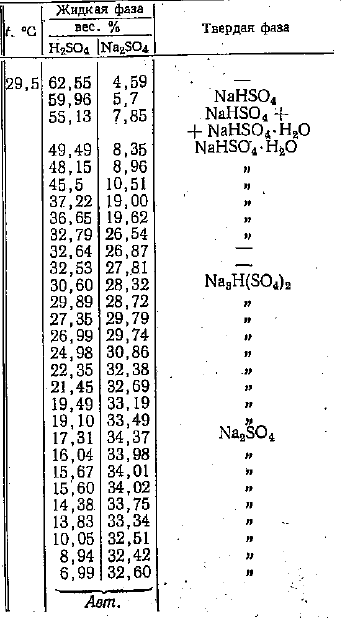

After examining the image, here are my thoughts on extracting the data into CSV format:

1. Column types:
   - Temperature: Float (°C)
   - H2SO4 concentration: Float (%)
   - Na2SO4 concentration: Float (%)
   - Solid phase: Text (chemical formulas)

2. Handling blanks:
   - Temperature: No blanks observed
   - H2SO4 and Na2SO4: Blanks appear meaningful and should be kept as empty cells
   - Solid phase: Blanks should be filled with the previous non-empty value

3. Special considerations:
   - The solid phase column contains multiple chemical formulas for some rows
   - Some rows have dashes (-) instead of values in the concentration columns
   - The last row contains "Дат." which may need special handling or translation

Overall metrics:
- Number of data rows: 33
- Proposed column headers: "Temperature (°C)", "H2SO4 (%)", "Na2SO4 (%)", "Solid Phase"
- Number of columns: 4

Additional notes:
- The table header contains merged cells and Cyrillic text that may need special handling
- Th

,temp,h2so4,na2so4,solid
2,29.5°C,62.55,4.59,nahso4
3,29.5°C,59.96,5.70,nahso4 + na3h(so4)2 + nahso4·h2o
4,29.5°C,55.13,7.85,nahso4·h2o
5,29.5°C,NaN,NaN,none


,temp,h2so4,na2so4,solid
2,49.49°C,8.35,NaN,nahso4·h2o
3,49.49°C,48.15,8.96,nahso4·h2o
4,49.49°C,45.50,10.51,nahso4·h2o
5,49.49°C,37.22,19.00,nahso4·h2o
6,49.49°C,36.65,19.62,nahso4·h2o
7,49.49°C,32.79,26.54,nahso4·h2o
8,49.49°C,32.64,26.87,nahso4·h2o
9,49.49°C,32.53,27.81,nahso4·h2o
10,49.49°C,30.60,28.32,na3h(so4)2
11,49.49°C,29.70,29.22,na3h(so4)2


Completed! ------------------------------------



- [i:1]------------ Parsing :../data/Capture2.PNG


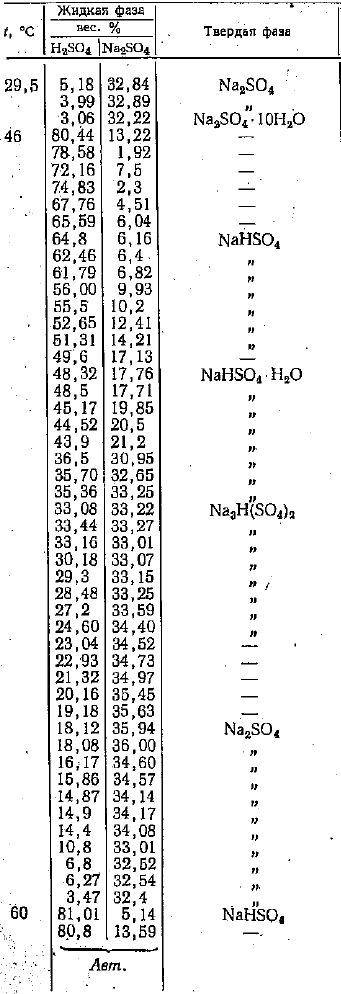

After examining the image, here are my thoughts on extracting this data into a CSV format:

1. Column types:
   - Temperature (t, °C): Float
   - Liquid phase H2SO4 %: Float
   - Liquid phase Na2SO4 %: Float
   - Solid phase: Text

2. Handling blanks:
   - Temperature: Blanks should be filled with the previous value
   - Liquid phase columns: Blanks are likely meaningful (indicating 0 or absence)
   - Solid phase: Blanks should be filled with the previous non-blank value

3. Special considerations:
   - Some temperature values have commas as decimal separators
   - There's an "Авт." row at the bottom that may need special handling
   - Some solid phase entries have multiple lines (e.g., "Na2SO4 • 10H2O")

4. Overall metrics:
   - Number of data rows: 61 (including the "Авт." row)
   - Proposed column headers: "Temperature (°C)", "H2SO4 (%)", "Na2SO4 (%)", "Solid Phase"
   - Number of columns: 4

5. Additional notes:
   - The table has merged cells in the header, which will need to be h

,temp,h2so4,na2so4,solid
2,29.5,5.18,32.84,na2so4
3,29.5,3.99,32.89,na2so4
4,29.5,3.06,32.22,na2so4 • 10h2o
5,29.5,NaN,NaN,none


,temp,h2so4,na2so4,solid
2,46,60.44,1.92,?
3,46,78.58,1.92,-
4,46,72.16,7.50,-
5,46,74.83,3.70,-
6,46,67.76,4.51,-
7,46,65.59,6.04,-
8,46,64.80,6.16,nahso4
9,46,62.46,6.40,nahso4
10,46,61.79,6.82,nahso4
11,46,56.00,9.93,nahso4


,temp,h2so4,na2so4,solid
2,60,81.01,5.14,nahso4
3,60,80.80,13.59,-


Completed! ------------------------------------



- [i:2]------------ Parsing :../data/Capture4.PNG


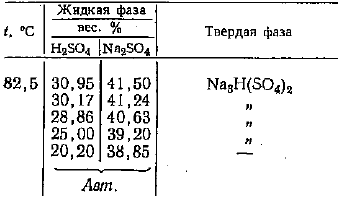

After examining the image and considering your description, here are my thoughts on extracting this data into a CSV format:

1. Column types and considerations:
   - Temperature (t, °C): Float values
   - H2SO4 concentration: Float values
   - Na2SO4 concentration: Float values
   - Solid phase: Text values

2. Handling blanks:
   - Temperature: No blanks observed
   - H2SO4 and Na2SO4 concentrations: No blanks observed
   - Solid phase: Blanks should be filled with the previous value (Na3H(SO4)2)

3. Special considerations:
   - The solid phase column contains a chemical formula
   - There's a row labeled "Авт." at the bottom, which might need special handling or translation
   - The merged cells in the header need to be carefully addressed when creating column names

4. Overall metrics:
   - Number of data rows: 6 (including the "Авт." row)
   - Proposed column headers: "Temperature (°C)", "H2SO4 (%)", "Na2SO4 (%)", "Solid Phase"
   - Number of columns: 4

5. CSV format consideration

,temp,h2so4,na2so4,solid
2,82.5,30.95,41.50,na3h(so4)2
3,82.5,30.17,41.24,na3h(so4)2
4,82.5,28.86,40.63,na3h(so4)2
5,82.5,25.00,39.39,na3h(so4)2
6,82.5,20.20,38.85,na3h(so4)2


Completed! ------------------------------------



- [i:3]------------ Parsing :../data/Capture.PNG


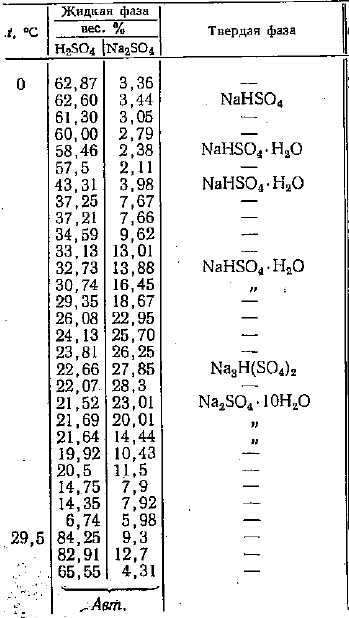

After examining the image, here are my thoughts on extracting the data into CSV format:

1. Temperature column:
   - Values appear to be floats
   - Some special values like "-29,5" at the bottom (likely -29.5)
   - Blanks should probably be filled with the previous value

2. H2SO4 concentration column:
   - Values are floats
   - No apparent blanks
   - Comma used as decimal separator

3. Na2SO4 concentration column:
   - Values are floats
   - No apparent blanks
   - Comma used as decimal separator

4. Solid phase column:
   - Text values (chemical formulas)
   - Many blanks - these are likely meaningful and should be left empty
   - Some entries have quotation marks (") which might need special handling

Special considerations:
- The decimal separator is a comma, which may need to be converted to a period for CSV format
- The negative temperature value at the bottom might need special attention
- Some chemical formulas contain periods, which could be mistaken for decimal points

Ove

,temp,h2so4,na2so4,solid
2,0°C,62.87,3.36,nahso4
3,0°C,62.60,3.14,
4,0°C,61.20,3.05,
5,0°C,60.00,2.79,
6,0°C,58.46,2.38,
7,0°C,57.50,2.11,
8,0°C,48.31,3.98,nahso4·h2o
9,0°C,37.25,7.67,
10,0°C,36.01,7.66,
11,0°C,34.59,9.62,


,temp,h2so4,na2so4,solid
2,-29.5°C,34.25,9.30,
3,-29.5°C,32.91,11.11,
4,-29.5°C,65.55,4.31,


Completed! ------------------------------------



- [i:4]------------ Parsing :../data/Capture5.PNG


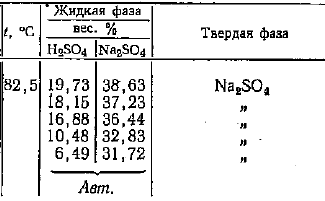

After examining the image and considering your description, here are my thoughts on extracting this data into a CSV format:

1. Column types and considerations:
   - Temperature (t, °C): Float values
   - Liquid phase H2SO4 (%): Float values
   - Liquid phase Na2SO4 (%): Float values
   - Solid phase: Text values

2. Handling blanks:
   - Temperature: No blanks observed
   - Liquid phase columns: No blanks observed
   - Solid phase: Blanks should be filled with the previous non-blank value (Na2SO4)

3. Special considerations:
   - The last row contains "Лит." in the temperature column, which appears to be a reference or note. This might need special handling or could be excluded from the data set.
   - The solid phase column contains only one unique value (Na2SO4), repeated for all rows.

4. Overall metrics:
   - Number of data rows: 6 (excluding the "Лит." row)
   - Proposed column headers: 
     "Temperature_C", "H2SO4_Percent", "Na2SO4_Percent", "Solid_Phase"
   - Number of columns:

,temp,h2so4,na2so4,solid
2,32.5,19.73,38.63,na2so4
3,32.5,18.15,37.29,na2so4
4,32.5,16.58,36.44,na2so4
5,32.5,14.32,35.18,na2so4
6,32.5,6.49,31.72,na2so4


Completed! ------------------------------------



- [i:5]------------ Parsing :../data/Capture3.PNG


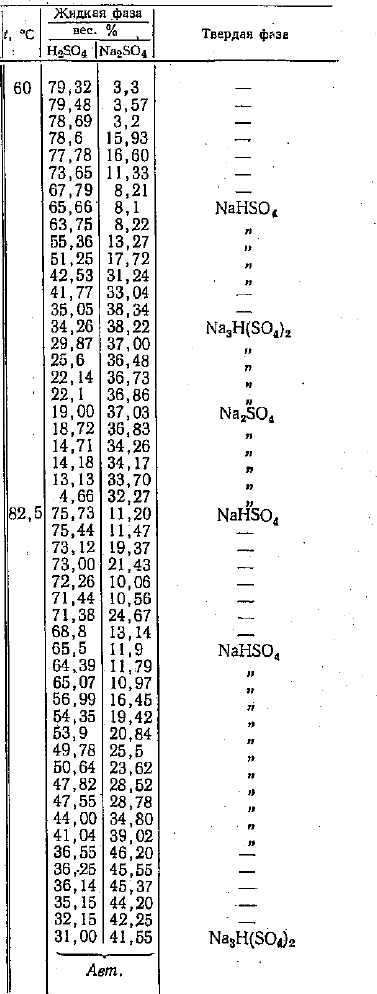

After examining the image, here are my thoughts on extracting this data into a CSV format:

1. Column types:
   - Temperature: Float (°C)
   - H2SO4 concentration: Float (%)
   - Na2SO4 concentration: Float (%)
   - Solid phase: Text (chemical formulas)

2. Handling blanks:
   - Temperature: No blanks observed
   - H2SO4 and Na2SO4: Blanks should be left empty, as they appear meaningful
   - Solid phase: Blanks should be filled with the previous non-empty value, as it seems to indicate the same solid phase continues

3. Special considerations:
   - There's a dash (-) in the solid phase column that may need user input on how to handle
   - Some rows have a single dash (-) in place of concentration values
   - The last row has "Авт." (possibly meaning "Author" or "Automatic") which may need special handling

4. Overall metrics:
   - Number of data rows: 61
   - Proposed column headers: "Temperature (°C)", "H2SO4 (%)", "Na2SO4 (%)", "Solid Phase"
   - Number of columns: 4

5. Additional n

,temp,h2so4,na2so4,solid
2,60°C,79.32,3.30,-
3,60°C,79.48,3.57,-
4,60°C,78.69,3.20,-
5,60°C,78.60,15.93,-
6,60°C,77.78,16.60,-
7,60°C,73.55,11.33,-
8,60°C,67.79,7.90,-
9,60°C,65.66,8.10,nahso4
10,60°C,63.75,8.22,nahso4
11,60°C,55.36,13.27,nahso4


,temp,h2so4,na2so4,solid
2,-32.5°C to 60°C,75.73,11.20,nahso4
3,-32.5°C to 60°C,75.44,11.47,nahso4
4,-32.5°C to 60°C,73.12,19.37,-
5,-32.5°C to 60°C,73.00,21.43,-
6,-32.5°C to 60°C,72.26,9.90,-
7,-32.5°C to 60°C,71.44,10.56,-
8,-32.5°C to 60°C,71.38,24.67,-
9,-32.5°C to 60°C,70.68,13.14,-
10,-32.5°C to 60°C,65.50,11.90,nahso4
11,-32.5°C to 60°C,64.39,NaN,nahso4


Completed! ------------------------------------





In [35]:
for i, image_filepath in enumerate(image_filepaths):
    print(f"- [i:{i}]------------ Parsing :{image_filepath}")
    #reset chat
    chat_manager.clear_conversation()
    
    prefix = pathlib.Path(image_filepath).stem
    answer = chat_manager.prompt(
        text="""Attached is an image of a data table that I want to extract data from.
    
        The table has multiple columns in a header that includes merged cells:
        - a temperature column
        - a liquid concentration for H2SO4
        - a liquid concentration for Na2SO4
        - a solid phase column with the chemical formula as the value
    
        Please reflect on this description as well as the image and think about how you would extract the data into a csv format.
        - include thoughts on the values that each column has (float, int, text, etc)
        - include thoughts on what blanks might mean in each column (blanks should be filled with previous value, blanks are meaningful values, etc)
        - include any special or unexpected values in each column the user should weigh in on
    
        Finally note the overall metrics for the table including:
        - the number of data rows
        - the proposed column headers
        - the number of columns
        """,
        image_filepath=image_filepath,
    )
    
    image_data = chat_manager.conversation[0]['content'][0]['source']['data']
    display(ipython.display.Image(b64decode(image_data)))
    
    print(answer)
    
    answer = chat_manager.prompt(
        text="""That is a pretty good plan. Lets go ahead and make a few modifications then extract the data. 
    
        Make sure you:
        - convert all russian or other language to english. Specifically the concentration units seem to have russian.
        - ignore and drop the "Дат." row
        - ignore the temperature column. Instead when you see a temperature value in a row start a new table corresponding to that value until the next time we see a temperature value.
        - handle the chemical formulas in a logical fashion.
    
        Be as accurate as possible and DONOT make up values. Only use values in the table. If you are unsure of a row indictae it with a "?" character
        """,
    )
    print(answer)
    
    answer = chat_manager.prompt(
        text="""Give back the data tables in a csv format that is easy to copy and paste.
    
        Choose identification strings we can easily search for later to parse indicating:
        - <identification_start> for the start of a table
        - <identification_end> for end of a table
        - <table_temperature> for the table temperature
    
        Answer with the following sections separated by lines:
        - START:<identification_start>
        - END:<identification_end>
        - TEMPERATURE:<table_temperature>
        - DATA: the csv data for each table with <identification_start> and <identification_end>
        """
    )
    print(answer)
    parse_csv_response(answer, filename_prefix=prefix)
    print("Completed! ------------------------------------\n\n\n")

In [38]:
csv_filepaths = [
    p
    for p in pathlib.Path(".").iterdir()
    if p.suffix in [".csv"]
]
csv_filepaths

[PosixPath('Capture2_0_table.csv'),
 PosixPath('Capture1_1_table.csv'),
 PosixPath('Capture5_0_table.csv'),
 PosixPath('Capture4_1_table.csv'),
 PosixPath('Capture1_0_table.csv'),
 PosixPath('Capture_1_table.csv'),
 PosixPath('Capture_0_table.csv'),
 PosixPath('Capture4_0_table.csv'),
 PosixPath('Capture3_0_table.csv'),
 PosixPath('Capture2_2_table.csv'),
 PosixPath('Capture2_1_table.csv'),
 PosixPath('Capture3_1_table.csv'),
 PosixPath('Capture4_2_table.csv')]

In [41]:
combined_df = pd.DataFrame()
for i, p in enumerate(csv_filepaths):
    df = pd.read_csv(p)
    df['i'] = p.stem
    combined_df = pd.concat([combined_df,df], axis=0)
combined_df.to_csv("combined_data.csv", index=False)